In [2]:
import numpy as np, matplotlib.pyplot as plt, numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

A system in Thermal Equilibrium with a temperature bath. The Probability $p_\mu$ of being in a state $\mu$ with Energy $E_\mu$ is $$p_\mu=\frac 1Z\exp(-\beta E_\mu)$$ where $Z=\sum_\mu \exp(-\beta E_\mu)$ is the Partition Function. At equilibrium the following $$\sum_\nu p_\mu P(\mu \to \nu)=\sum_\nu p_\nu(\nu \to \mu)$$ must be true, where $P(\mu \to v)$ is the probability of going from state $\mu$ to state $\nu$. For our numerical methods, we can make this true by setting the detailed balance condition $$p_\mu P(\mu \to \nu)=p_\nu P(\nu \to \mu)$$

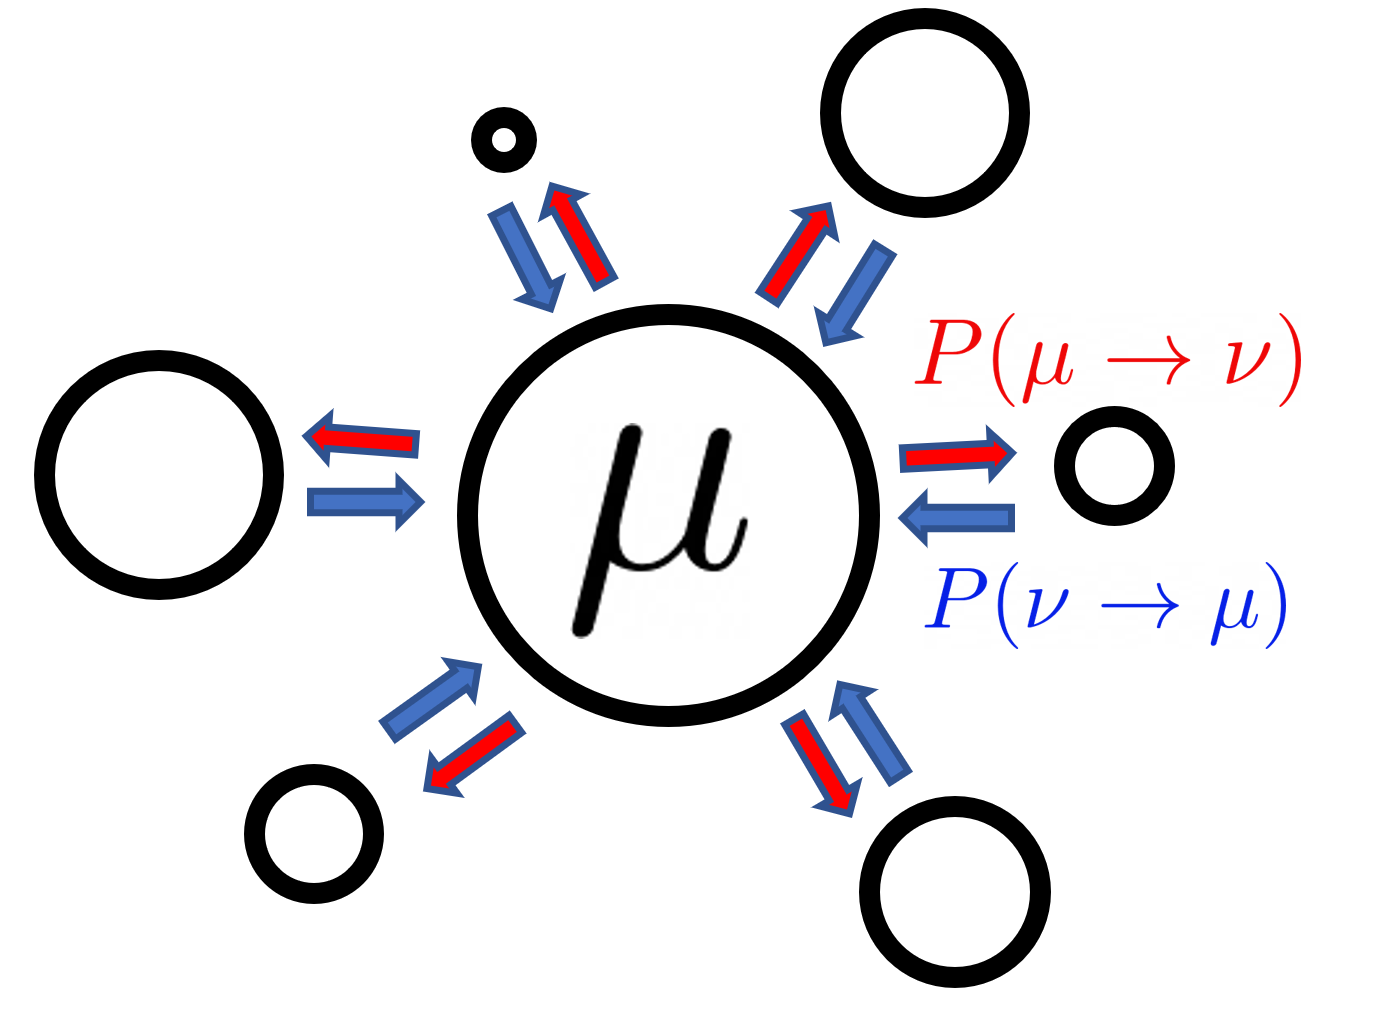

In [6]:
from IPython.display import Image
Image(filename = r'..\Images\ising.png')

# The Ising Model:

The Total Energy is $$E_\mu=\sum_{\langle i,j\rangle}-J\sigma_i\sigma_j$$ where $\sigma_i$ is the Spin of a single particle in the lattice (either 1 or -1) and the sum over $\langle i,j\rangle$ means summing over nearest neighbours for all lattice points. $\mu$ correseponds to a particular Spin configuration. Satisfying detailed balance: $$\frac{P(\mu \to \nu)}{P(\nu \to \mu)}=\frac{p_\nu}{p_\mu}=\exp[-\beta(E_\nu-E_\mu)]$$

# The Metropolis Algorithm:

We wanna find the Equilibrium State $\mu$ in the magnet at a particular temperature $\beta$ (the number of $\sigma_i$ are 1, as well as how many are -1). We'll start ith a random lattice of Spins, some pointing Up and some Down, and make it dance around using the above equation until it fixes itself into equillibrium.

1. Call the Current State $\mu$.
2. Pick a random particle on the lattice, flip the Spin sign and call the state $\nu$. We wanna find the Probability that $P(\mu \to \nu)$ that we'll accept this new state.
3. 
    - If $E_\nu>E_\mu$ then set $P(\nu \to \mu)=1$ and thus the Detailed Balance Equation $P(\mu \to \nu)=\exp[-\beta(E_\nu-E_\mu)]$.
    - If $E_\mu>E_\nu$ then set $P(\mu \to \nu)=1$ and this still satisfies the Detailed Balance.


4. Change to state $\nu$ (flip the Spin) with the probabilities outlined above.
5. Repeat from the start many, many times and eventually we'll force out an Equilibrium State. 

Thus, the only thing that needs to be evaluated is $-\beta(E_\nu-E_\mu)=-\beta J\sum_{k=1}^4\sigma_i\sigma_k$ where $i$ is the Spin being flipped and the $\sigma_k$ are the four nearest neighbours to that Spin in $\mathbb R^2$. On the boundaries, sometimes Spins might have less than 4 though.

Let's make a $N\times N$ grid for any choice of $N$:

In [7]:
N = 50

init_random = np.random.random((N, N))

lattice_n = np.zeros((N, N))

lattice_n[init_random > 0.75] = 1
lattice_n[init_random < 0.75] = -1

lattice_p = np.zeros((N, N))

lattice_p[init_random >= 0.25] = 1
lattice_p[init_random < 0.25] = -1

Initial Lattice of Spins:

Text(0, 0.5, '$y$')

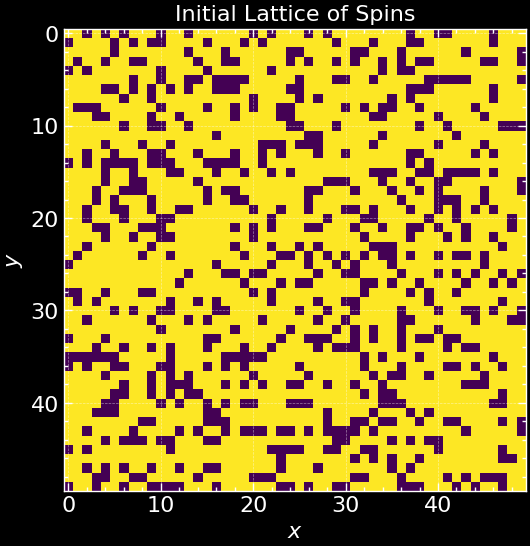

In [9]:
plt.imshow(lattice_p)

plt.title('Initial Lattice of Spins')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Let's get the Energy $E/J=-\sum_{\langle i,j\rangle}\sigma_i\sigma_j$:

In [10]:
def energy(lattice):
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False

    arr = -lattice * convolve(lattice, kern, mode = 'constant')
    return arr.sum()

energy(lattice_p)

-2180.0

The Metropolis Algorithm:

In [13]:
@numba.jit('UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)', nopython = True, nogil = True)

def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    
    net_spins = np.zeros(times - 1)
    net_energy = np.zeros(times - 1)

    for t in range(0, times - 1):
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)

        spin_i = spin_arr[x, y]
        spin_f = spin_i * -1

        E_i = 0
        E_f = 0
        
        if x > 0:
            E_i += -spin_i * spin_arr[x - 1, y]
            E_f += -spin_f * spin_arr[x - 1, y]

        if x < N - 1:
            E_i += -spin_i * spin_arr[x + 1, y]
            E_f += -spin_f * spin_arr[x + 1, y]

        if y > 0:
            E_i += -spin_i * spin_arr[x, y - 1]
            E_f += -spin_f * spin_arr[x, y - 1]

        if y < N - 1:
            E_i += -spin_i * spin_arr[x, y + 1]
            E_f += -spin_f * spin_arr[x, y + 1]

        dE = E_f - E_i

        if (dE > 0) * (np.random.random() < np.exp(-BJ * dE)):
            spin_arr[x, y] = spin_f
            energy += dE
        
        elif dE < 0:
            spin_arr[x, y] = spin_f
            energy += dE

        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy

    return net_spins, net_energy

spins, energies = metropolis(lattice_n, 1e+06, 0.7, energy(lattice_n))

Text(0.5, 0.98, 'For $\\beta J=$0.7')

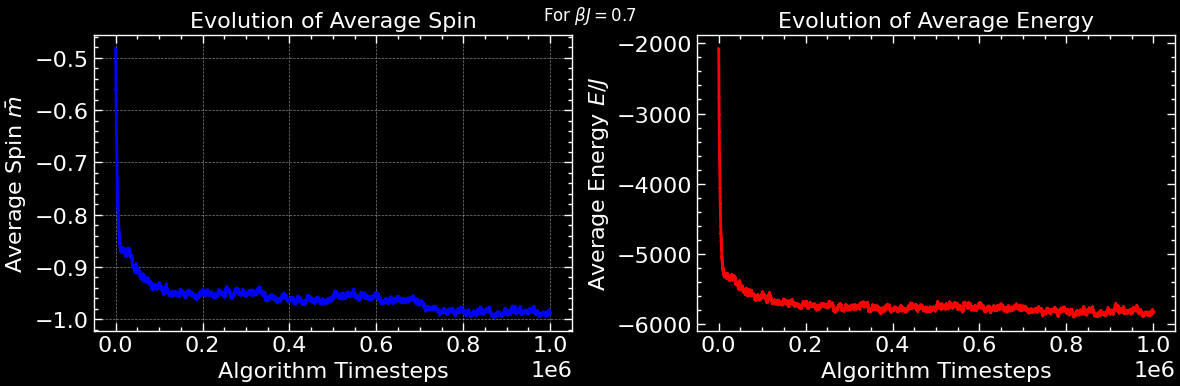

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

ax = axes[0]

ax.plot(spins / N ** 2, color = 'blue')

ax.set_title(r'Evolution of Average Spin')
ax.set_xlabel('Algorithm Timesteps')
ax.set_ylabel(r'Average Spin $\bar{m}$')

ax = axes[1]

ax.plot(energies, color = 'red')

ax.set_title(r'Evolution of Average Energy')
ax.set_xlabel('Algorithm Timesteps')
ax.set_ylabel(r'Average Energy $E/J$')

ax.grid()
fig.tight_layout()
fig.suptitle(r'For $\beta J=$0.7')

We can get an average for $\bar{m}$ and $E/J$ for many different $\beta J$ values, which would be the average of the last 1e+06 points on the figure above.

In [21]:
def spin_energy(lattice, BJ_values):
    m_values = np.zeros(len(BJ_values))

    E_avg = np.zeros(len(BJ_values))
    E_std = np.zeros(len(BJ_values))

    for i, BJ in enumerate(BJ_values):
        spins, energies = metropolis(lattice, 1000000, BJ, energy(lattice))

        m_values[i] = spins[-1000000:].mean()
        
        E_avg[i] = energies[-1000000:].mean()
        E_std[i] = energies[-1000000:].std()

    return m_values, E_avg, E_std

BJ_values = np.arange(0.1, 2, 0.05)

m_values_n, E_avg_n, E_std_n = spin_energy(lattice_n, BJ_values)
m_values_p, E_avg_p, E_std_p = spin_energy(lattice_p, BJ_values)

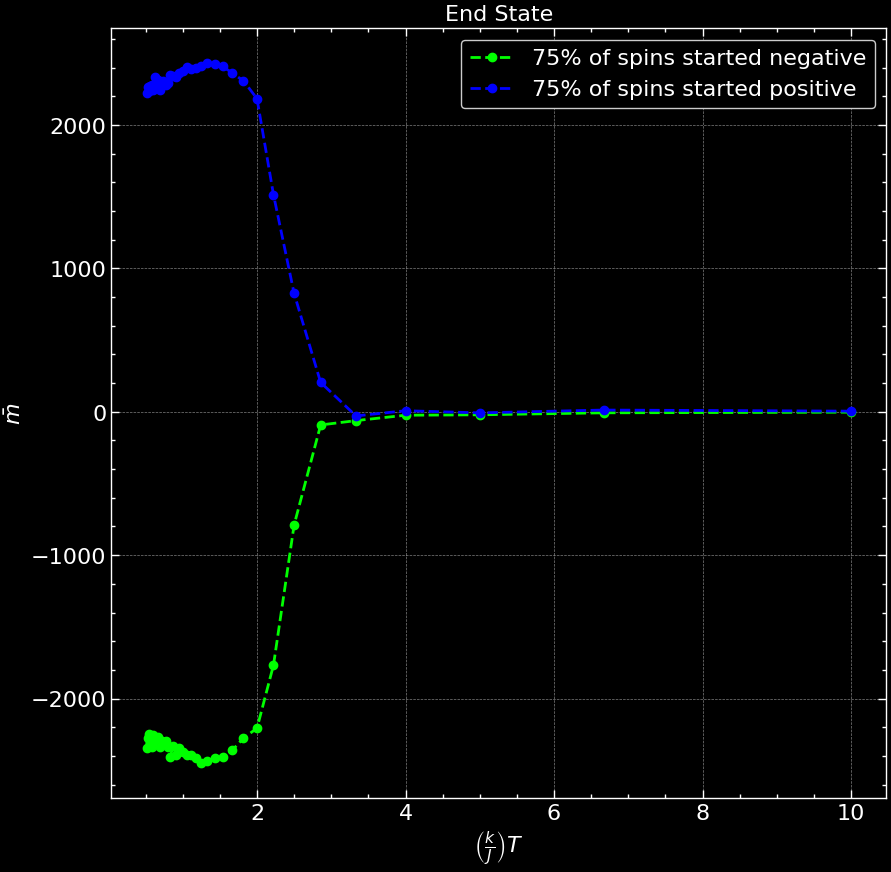

In [27]:
plt.figure(figsize = (10, 10))
plt.plot(1 / BJ_values, m_values_n, 'o--', label = r'75% of spins started negative', color = 'lime')
plt.plot(1 / BJ_values, m_values_p, 'o--', label = r'75% of spins started positive', color = 'blue')

plt.title('End State')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(framealpha = 1)

Let's plot the Heat Capacity as a function of Temperature, using the fact that $$C_v=\frac{\sigma_E^2}{T^2}$$ where $\sigma_E$ is the Standard Deviation in Energy. This hence becomes $$\Bigg[\Bigg\langle\bigg(\frac EJ\bigg)^2\Bigg\rangle-\bigg\langle\frac EJ\bigg\rangle^2\Bigg]\cdot (\beta J)^2k^2$$ which is exactly $\sigma_{E/J}^2(\beta Jk)^2$.

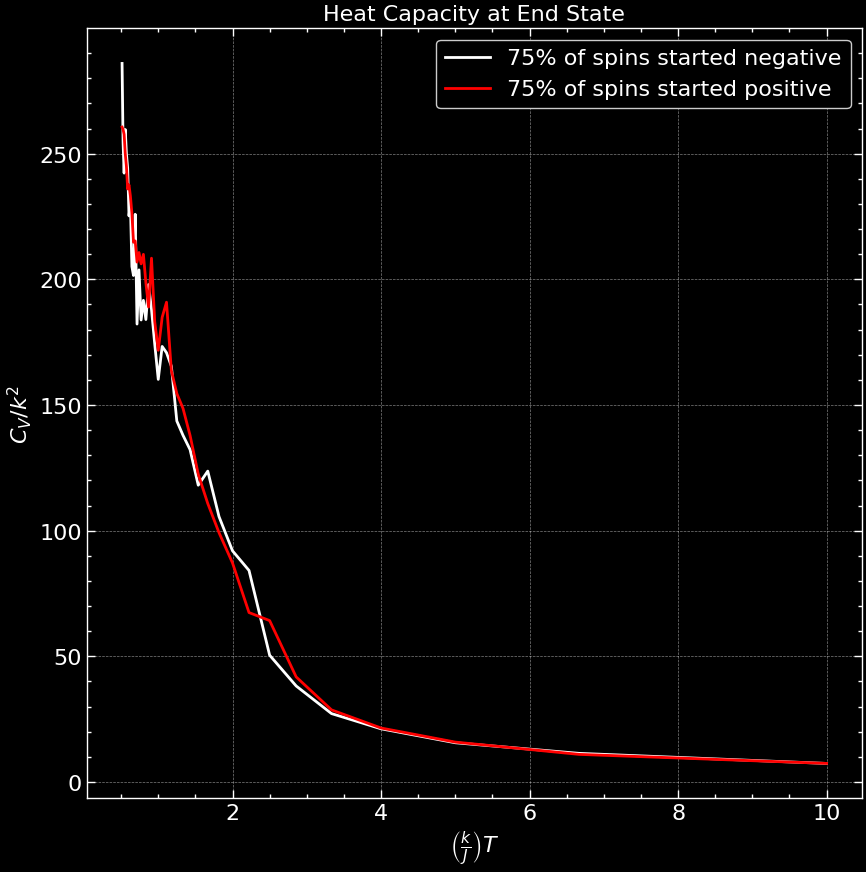

In [29]:
plt.figure(figsize = (10, 10))
plt.plot(1 / BJ_values, E_std_n * BJ_values, label = r'75% of spins started negative', color = 'white')
plt.plot(1 / BJ_values, E_std_p * BJ_values, label = r'75% of spins started positive', color = 'red')

plt.title('Heat Capacity at End State')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V/k^2$')
plt.legend(framealpha = 1)